In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as x
from numba import njit
from tqdm import tqdm
import torch
import scipy

dtype = torch.float32
K = 7.5
n_r = 6
R = 2 / 3 * 10**6
C = 30 * 10**-12
V_r = -70 * 10**-3
theta = -50 * 10**-3
w_e = 95 * 10**-12
p_r = 0.25
tau_rp = 1 * 10**-3
tau_s = 5 * 10**-3
tau_R = 0.1
device = "cuda"

w_in = 50 * 10**-12
N = 100
f = 5
dt = 0.0001
T = 1


In [3]:
time_steps = int(T / dt)
poisson_I = torch.tensor(
    np.random.poisson(f * dt, (N, time_steps)), device=device, dtype=dtype
)
spikes = torch.zeros((N, time_steps), device=device, dtype=dtype)
U = torch.zeros((N, time_steps, n_r), device=device, dtype=dtype)
U[:, 0, :] = 1
V = torch.zeros(N, device=device, dtype=dtype) + V_r
Sleep = torch.zeros(N, device=device, dtype=dtype)
Switch = Sleep == 0

Graph = x.erdos_renyi_graph(N, K / N, seed=0, directed=False)
A = torch.zeros((N, N), device=device, dtype=dtype)
B = x.adjacency_matrix(Graph)
for edge in list(Graph.edges):
    A[edge[0], edge[1]] = +1

t_span = torch.tile(torch.arange(0, T, dt, device=device, dtype=dtype), (N, 1))

def get_I_ext(t):
    I_ext = torch.zeros(N, device=device, dtype=dtype)
    step = int(t / dt)
    fired = torch.zeros((N, time_steps), device=device, dtype=dtype)
    fired[:, :step] = poisson_I[:, :step]
    return w_e * torch.sum(
        (torch.exp((-(t - t_span * poisson_I) / tau_s) * fired) * fired), dim=1
    )

def get_I_in(t, U, spikes):
    step = int(t / dt)
    opening = p_r * (U * spikes.reshape((N, time_steps, 1)))
    eta = torch.rand(opening.shape, device=device, dtype=dtype)

    fired = torch.zeros((N, time_steps), device=device, dtype=dtype)
    fired[:, :step] = spikes[:, :step]
    gate = torch.sum(
        torch.exp((-(t - t_span * spikes) / tau_s) * fired)
        * fired
        * torch.heaviside(
            opening - eta, torch.zeros_like(eta, device=device, dtype=dtype)
        ).sum(2),
        dim=1,
    )
    return w_in * A @ gate

def V_dot(V, t, U, spikes):
    return -(V - V_r) / (R * C) + get_I_ext(t) / C + get_I_in(t, U, spikes) / C

def U_dot(t, U):
    # U_dot = torch.zeros((N, 6), device=device, dtype=dtype)
    step = int(t / dt)
    # opening = spikes[:, step].reshape((-1, 1))
    # eta = torch.rand((N, n_r), device=device, dtype=dtype)
    U_dot = (
        1 - U[:, step]
    ) / tau_R  # - ((torch.heaviside(p_r - eta ,torch.zeros_like(eta,device=device)) * opening) * U[:,step])
    return U_dot




for step in tqdm(range(time_steps - 1)):
    Sleep -= (Sleep > 0) * dt
    Switch = Sleep <= 0

    t = step * dt

    dU = U_dot(t, U) * dt
    dV = V_dot(V, t, U, spikes) * dt

    U[:, step + 1, :] = U[:, step, :] + dU

    V += dV * Switch

    is_spike = V > theta
    V[is_spike] = V_r
    U[is_spike, step + 1] = 0
    spikes[:, step] = is_spike

    Sleep += tau_rp * is_spike



# torch.save(spikes, f"{N}_{f}_{T}_{w_in*10**12}.pt")




100%|██████████| 9999/9999 [00:19<00:00, 508.61it/s]


/tmp/ipykernel_460400/2130793640.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("spikes.png")
/tmp/ipykernel_460400/2130793640.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("spikes.png")
/tmp/ipykernel_460400/2130793640.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("spikes.png")
/tmp/ipykernel_460400/2130793640.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inches_restore" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("spikes.png")


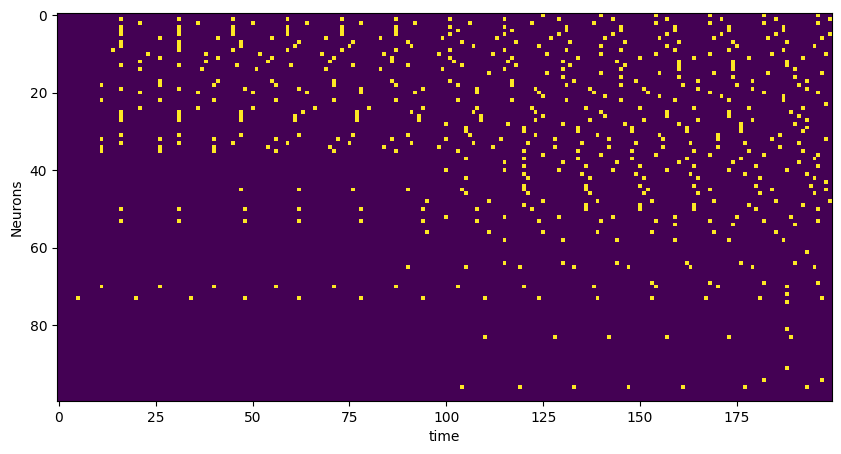

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(spikes[:,:200].cpu())
plt.ylabel("Neurons")
plt.xlabel("time")
plt.savefig("spikes.png")

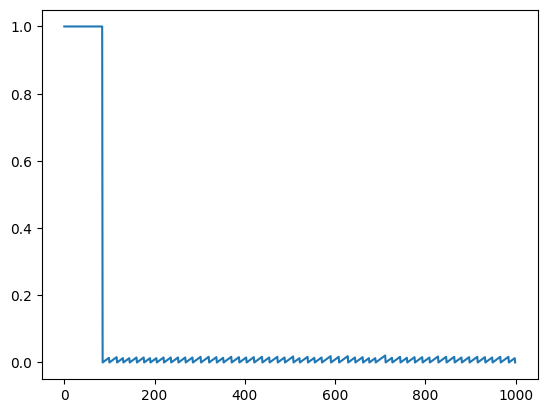

In [40]:
plt.plot(torch.arange(U[0,:1000,0].shape[0]) , U[0,:1000,0].cpu())

/tmp/ipykernel_103285/3116004277.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("activity_time.png")
/tmp/ipykernel_103285/3116004277.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("activity_time.png")
/tmp/ipykernel_103285/3116004277.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("activity_time.png")
/tmp/ipykernel_103285/3116004277.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inches_restore" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("activity_time.pn

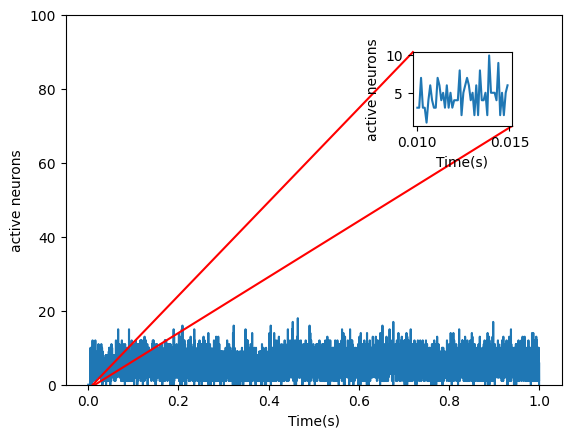

In [31]:
fig, ax = plt.subplots(1)
ins = ax.inset_axes([0.7,0.7,0.2,0.2])


ax.plot(np.arange(time_steps)*T/time_steps,spikes.sum(0).cpu())
ax.set_ylim((0,N))
ax.set_ylabel("active neurons")
ax.set_xlabel("Time(s)")


index1 = 100
index2 = 150
ins.plot((np.arange(time_steps)*T/time_steps)[index1:index2],spikes.sum(0).cpu()[index1:index2])
# ins.set_ylim((0,N))
ins.set_ylabel("active neurons")
ins.set_xlabel("Time(s)")


# ax.plot([(np.arange(time_steps)*T/time_steps)[index1], 0.72] , [0,70] , c="r" )
ax.plot([(np.arange(time_steps)*T/time_steps)[index1], 0.72] , [0,90] , c="r" )
ax.plot([(np.arange(time_steps)*T/time_steps)[index2], 0.94] , [0,70] , c="r")
# ax.plot([(np.arange(time_steps)*T/time_steps)[index2], 0.94] , [0,90] , c="r")


plt.savefig("activity_time.png")


Text(0.5, 0, 'Time(s)')

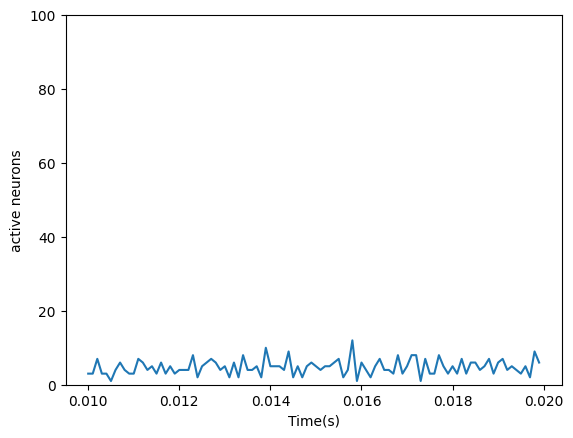

In [1]:


print("num spikes : ", torch.sum(spikes).cpu())
time_steps = spikes.shape[1]

plt.imshow(spikes[:,:].cpu())
plt.show()
plt.plot(torch.arange(time_steps)[:],spikes.sum(0)[:].cpu())
plt.show()
print(spikes.sum(0).mean().cpu())



avalanch = spikes.sum(0) != 0
slippingR = avalanch.roll(+1)
slippingL = avalanch.roll(-1)
slippingR[0] = False
slippingL[-1] = False

ends  = torch.logical_xor( avalanch ,(avalanch *slippingL))
starts  = torch.logical_xor( avalanch ,(avalanch *slippingR))

spikes_sum = torch.cumsum(spikes.sum(dim = 0),dim = 0)

avalanches_size = spikes_sum[torch.where(ends)[0]] - spikes_sum[torch.where(starts)[0]] + 1

# nbins = 20
# bins = np.exp(np.linspace(np.log(avalanches_size.cpu().min()), np.log(avalanches_size.cpu().max()) , nbins))
bins = 50
freq,size = np.histogram(avalanches_size.cpu(),bins = bins)
size = (size[:-1] + size[1:])/2

slope , intercept, rvalue ,_,_= scipy.stats.linregress(np.log(size[freq != 0]),np.log(freq[freq != 0]))
print(slope)




plt.scatter(np.log(size[freq != 0]),np.log(freq[freq != 0]))
plt.plot([np.log(size[freq != 0])[0],np.log(size[freq != 0][-1])],[intercept,intercept + slope * np.log(size[freq != 0][-1])])
plt.text(6,4,f"slope = {np.round(slope,3)}")
plt.show()



avalanches_steps = torch.where(ends) [0] -   torch.where(starts)[0] + 1


# nbins = 10
# bins = np.exp(np.linspace(np.log(avalanches_size.cpu().min()), np.log(avalanches_size.cpu().max()) , nbins))
bins = 50
freq,size = np.histogram(avalanches_steps.cpu(),bins = 10)
size = (size[:-1] + size[1:])/2


slope , intercept, rvalue ,_,_= scipy.stats.linregress(np.log(size[freq != 0]),np.log(freq[freq != 0]))
print(slope)


plt.scatter(np.log(size[freq != 0]),np.log(freq[freq != 0]))
plt.plot([np.log(size[freq != 0])[0],np.log(size[freq != 0][-1])],[intercept,intercept + slope * np.log(size[freq != 0][-1])])
plt.text(6,4,f"slope = {np.round(slope,3)}")
plt.show()


NameError: name 'torch' is not defined